In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rs3.seq import predict_seq
import matplotlib
import gpplot

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
inpath = '../Data/CleanedExternalData/'

NewDatasetCombine = pd.read_csv(inpath + 'DatasetCombineCleaned_v3.csv', low_memory=False)


In [3]:
any('u' in seq for seq in NewDatasetCombine['sgRNA Context Sequence'])

False

In [4]:
any('U' in seq for seq in NewDatasetCombine['sgRNA Context Sequence'])

False

In [5]:

# Function to make upper case

def to_upper_case(seq_list):
    return ''.join([seq.upper() for seq in seq_list])

# Apply the function to the 'sequences' column
NewDatasetCombine['sgRNA Context Sequence'] = NewDatasetCombine['sgRNA Context Sequence'].apply(to_upper_case)


In [6]:
NewDatasetCombine.DataSet.value_counts()

InHouse    344011
Nunez       68575
Gilbert     18509
Name: DataSet, dtype: int64

In [7]:
NewDatasetCombine['rs3ChenSeqScore'] =  predict_seq(NewDatasetCombine['sgRNA Context Sequence'], sequence_tracr='Chen2013')

Calculating sequence-based features


100%|██████████████████████████████████| 431095/431095 [23:11<00:00, 309.82it/s]


In [10]:
NewDatasetCombine['cellDomainDataSet'] = NewDatasetCombine[['condition', 'Domain', 'DataSet']].apply(
    lambda x: "_".join(x.astype(str)), axis=1)

In [11]:
NewDatasetCombine['orginal phenotype'] = NewDatasetCombine['Phenotype scores-ave_Rep1_Rep2'].combine_first(NewDatasetCombine['z_scored_avg_lfc']).combine_first(NewDatasetCombine['rhoSignChangedAndAvged'])


42570
42609
42609
42544


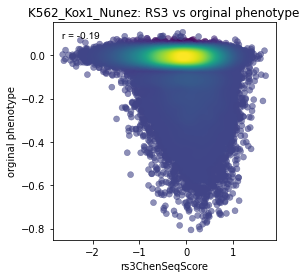

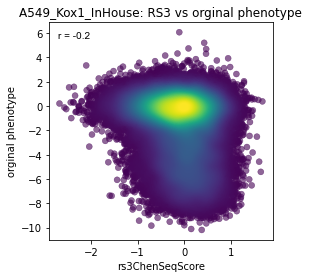

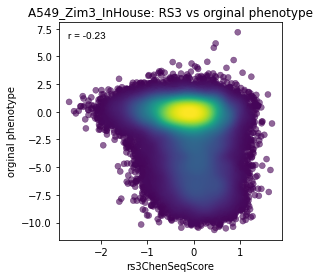

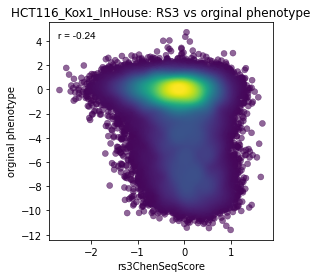

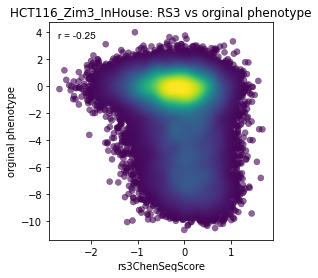

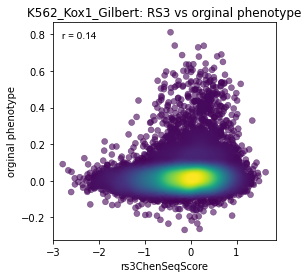

In [12]:
ess_noness = pd.read_csv('../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
graph_pathout = '../Figure/Figure 3/Individual Figures/'

for unique_set in NewDatasetCombine['cellDomainDataSet'].unique():
    SubsetNewDatasetCombine = NewDatasetCombine[NewDatasetCombine['cellDomainDataSet']== unique_set]
    if 'InHouse' in unique_set:
        SubsetNewDatasetCombine = SubsetNewDatasetCombine[SubsetNewDatasetCombine['Target Gene Symbol'].\
                                                                  isin(EssGene)]
        print(len(SubsetNewDatasetCombine))

    fig, ax = plt.subplots(figsize = (4,4))
    ax = gpplot.point_densityplot(data=SubsetNewDatasetCombine, x='rs3ChenSeqScore', y='orginal phenotype', palette=gpplot.sequential_cmap())
    ax = gpplot.add_correlation(data=SubsetNewDatasetCombine, x='rs3ChenSeqScore', 
                                y='orginal phenotype', method = 'spearman')
    plt.xlabel('rs3ChenSeqScore')
    plt.ylabel('orginal phenotype')
    plt.title(unique_set + ': RS3 vs orginal phenotype')
    #plt.savefig(graph_pathout + unique_set+"_RS3.pdf", dpi=300, bbox_inches='tight')

In [13]:
# ess gene
ess_noness = pd.read_csv('../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
InhouseEss = NewDatasetCombine[(NewDatasetCombine.DataSet == 'InHouse') & (NewDatasetCombine['Target Gene Symbol'].isin(EssGene))]
other = NewDatasetCombine[~(NewDatasetCombine.DataSet == 'InHouse')]
newData = pd.concat([InhouseEss,other])

withinGeneCorr = newData.groupby(['cellDomainDataSet','Target Gene Symbol'])[['orginal phenotype', 'rs3ChenSeqScore']].corr('spearman').unstack().iloc[:, 1]

In [14]:

withinGeneCorr = withinGeneCorr.reset_index()


In [15]:
withinGeneCorr.columns = ['cellDomainDataSet', 'Target Gene Symbol', 'spearman correlation']

In [18]:
withinGeneCorr.cellDomainDataSet.value_counts()

K562_Kox1_Nunez        336
A549_Kox1_InHouse      144
A549_Zim3_InHouse      144
HCT116_Kox1_InHouse    144
HCT116_Zim3_InHouse    144
K562_Kox1_Gilbert       36
Name: cellDomainDataSet, dtype: int64

In [21]:
# Identify the condition
condition = (withinGeneCorr.cellDomainDataSet == 'K562_Kox1_Nunez') | \
(withinGeneCorr.cellDomainDataSet == 'A549_Kox1_InHouse') | \
(withinGeneCorr.cellDomainDataSet == 'A549_Zim3_InHouse') | \
(withinGeneCorr.cellDomainDataSet == 'HCT116_Kox1_InHouse') | \
(withinGeneCorr.cellDomainDataSet == 'HCT116_Zim3_InHouse') 

# Apply the condition to locate the indices and then modify the values using .loc
withinGeneCorr.loc[condition, 'spearman correlation'] *= -1



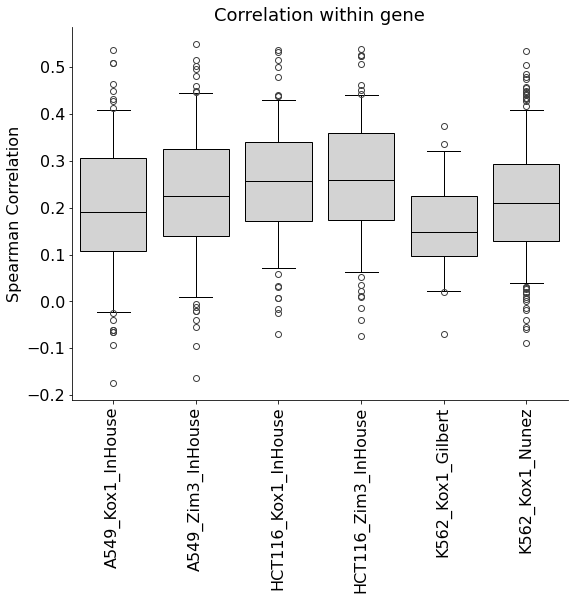

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cellDomainDataSet', y='spearman correlation', 
            data=withinGeneCorr, boxprops=dict(facecolor='lightgrey', edgecolor='black'),
                 whiskerprops=dict(color='black'),  # Whisker line color
                 capprops=dict(color='black'),  # Cap line color
                 medianprops=dict(color='black'), whis = [5,95])
plt.title('Correlation within gene',fontsize=18)
plt.xlabel('')
plt.ylabel('Spearman Correlation',fontsize=16)
plt.tight_layout()
for line in ax.lines:
    line.set_linewidth(2)  # Set whisker, cap, and median line width (increase the value as needed)

plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
sns.despine()

plt.savefig(graph_pathout + "AllData_RS3_withinGene_v2.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
medians = withinGeneCorr.groupby('cellDomainDataSet')['spearman correlation'].median()
print(medians)

cellDomainDataSet
A549_Kox1_InHouse      0.191080
A549_Zim3_InHouse      0.225682
HCT116_Kox1_InHouse    0.256199
HCT116_Zim3_InHouse    0.259000
K562_Kox1_Gilbert      0.147578
K562_Kox1_Nunez        0.209562
Name: spearman correlation, dtype: float64


In [39]:
# an example
A549_Kox1_InHouse_dataset = NewDatasetCombine[NewDatasetCombine.cellDomainDataSet == 'A549_Kox1_InHouse']

In [40]:


withinGeneCorr_A549_Kox1_InHouse_dataset = A549_Kox1_InHouse_dataset.groupby(['cellDomainDataSet','Target Gene Symbol'])[['orginal phenotype', 'rs3ChenSeqScore']].corr('spearman').unstack().iloc[:, 1]
withinGeneCorr_A549_Kox1_InHouse_dataset = withinGeneCorr_A549_Kox1_InHouse_dataset.reset_index()
withinGeneCorr_A549_Kox1_InHouse_dataset.columns = ['cellDomainDataSet', 'Target Gene Symbol', 'spearman correlation']
withinGeneCorr_A549_Kox1_InHouse_dataset = pd.merge(withinGeneCorr_A549_Kox1_InHouse_dataset, ess_noness[['Target Gene Symbol', 'Category']].drop_duplicates())

In [41]:
withinGeneCorr_A549_Kox1_InHouse_dataset

,cellDomainDataSet,Target Gene Symbol,spearman correlation,Category
0,A549_Kox1_InHouse,AATF,-0.177706,Essential
1,A549_Kox1_InHouse,ACCSL,-0.076332,Non-essential
2,A549_Kox1_InHouse,ADGRF2,-0.068263,Non-essential
3,A549_Kox1_InHouse,ALG14,0.093960,Essential
4,A549_Kox1_InHouse,ALX3,-0.039535,Non-essential
...,...,...,...,...
328,A549_Kox1_InHouse,YEATS4,0.038623,Essential
329,A549_Kox1_InHouse,YY1,-0.182299,Essential
330,A549_Kox1_InHouse,ZIM3,0.139873,Non-essential
331,A549_Kox1_InHouse,ZNF131,-0.082829,Essential


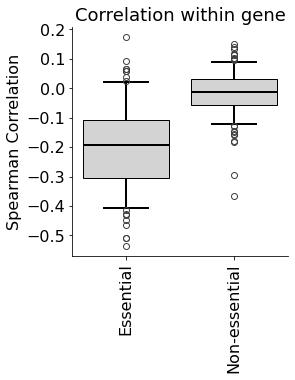

In [74]:
plt.figure(figsize=(4,4))
ax = sns.boxplot(x='Category', y='spearman correlation',
            data=withinGeneCorr_A549_Kox1_InHouse_dataset, boxprops=dict(facecolor='lightgrey', edgecolor='black'),
                 whiskerprops=dict(color='black'),  # Whisker line color
                 capprops=dict(color='black'),  # Cap line color
                 medianprops=dict(color='black'), whis = [5,95])
plt.title('Correlation within gene',fontsize=18)
plt.xlabel('')
plt.ylabel('Spearman Correlation',fontsize=16)
plt.tight_layout()
for line in ax.lines:
    line.set_linewidth(2)  # Set whisker, cap, and median line width (increase the value as needed)

plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
sns.despine()
plt.savefig(graph_pathout + 'A549Kox1_RS3_withinGene.pdf', dpi=300, bbox_inches='tight')
